In [12]:
import torch
import os
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utils import plot_image, cellboxes_to_boxes

In [2]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []

        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, w, h = [float(x) if float(x) != int(float(x)) else int(x) for x in label.replace("\n", "").split()]
                boxes.append([class_label, x, y, w, h])
        
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, w, h = box
            class_label = int(class_label)
            # calculating the cell no where the object's midpoint is located
            i, j = int(self.S * y), int(self.S * x)
            # for calculating relative to that cell
            x_cell, y_cell = self.S * x - j, self.S * y - i
            width_cell, height_cell = w * self.S, h * self.S

            if label_matrix[i, j, 20] == 0.0:
                label_matrix[i, j, 20] = 1
                label_matrix[i, j, 21:25] = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell])
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [3]:
my_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor()
])

dataset = VOCDataset(csv_file="../VOC/train.csv", img_dir="../VOC/images",
                     label_dir="../VOC/labels", transform=my_transform)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
sampled = iter(train_loader)
sampled = next(sampled)

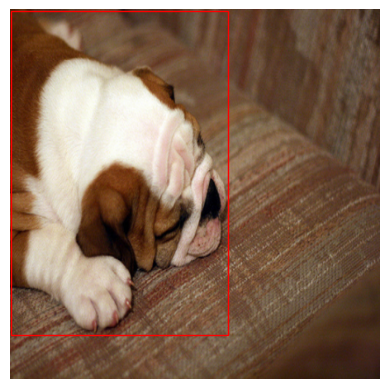

In [44]:
idx = np.random.randint(len(sampled[0]))
x, y = sampled[0], sampled[1]
bboxes = cellboxes_to_boxes(y)

plot_image(x[idx].permute(1, 2, 0), bboxes[idx])